# Plan of Action

In [124]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import cv2
import os
import time
import itertools
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras import models,layers 
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible

np.random.seed(42)
tf.random.set_seed(42)

In [55]:
path = "../input/content/content/combined_faces_train_augmented"


pixels = []
ages = []

for img_name in os.listdir(path):
    # Construct full path to the image
    img_path = os.path.join(path, img_name)
    
    # Extract the age from the filename (two digits before the underscore)
    try:
        age = int(img_name.split("_")[0])
    except ValueError:
        # Handle cases where the filename format is unexpected
        print(f"Filename format error: {img_name}")
        continue

    # Read the image
    img = cv2.imread(img_path)
    
    if img is None:
        # Handle cases where the image cannot be read
        print(f"Error reading image: {img_path}")
        continue
    
    # Convert the image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to 100x100 pixels
    img=cv2.resize(img,(100,100))
    img = img / 255.0
    
    # Append pixel data and age to the lists
    pixels.append(img)
    ages.append(age)

# Convert lists to numpy arrays
pixels = np.array(pixels)
ages = np.array(ages, dtype=np.uint64)

In [56]:
print(np.shape(pixels))

(17687, 100, 100)


In [57]:
print(type(ages))

<class 'numpy.ndarray'>


In [58]:
len(ages)

17687

## Define Age Classes

In [59]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.
def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6


In [60]:
train_age = np.array([class_labels_reassign(age) for age in ages])

In [118]:
num_classes = 7
my_models = {}
model_rmse = {}
train_age_categorical = to_categorical(train_age, num_classes=num_classes)
ages = train_age_categorical

In [62]:
imagen_size = 100
batch_size  = 64

In [63]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    pixels, ages, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42)

In [64]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

In [65]:
datagen = ImageDataGenerator()
datagen_val =ImageDataGenerator()
train_set = train_generator = datagen.flow(
    X_train,              
    y_train,  
    batch_size=batch_size,
    shuffle=True         
)

val_set = train_set = train_generator = datagen_val.flow(
    X_val,              
    y_val,  
    batch_size=batch_size,
    shuffle=False         )

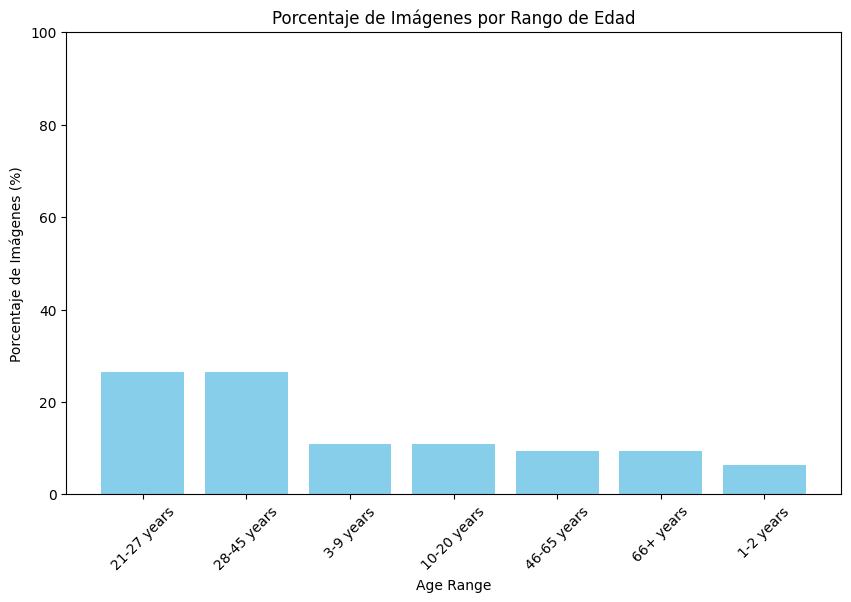

In [66]:
class_names = [
    "1-2 years",  # Clase 0
    "3-9 years",  # Clase 1
    "10-20 years",  # Clase 2
    "21-27 years",  # Clase 3
    "28-45 years",  # Clase 4
    "46-65 years",  # Clase 5
    "66+ years"  # Clase 6
]

# Inicializar un diccionario para contar las imágenes por clase
image_counts = {label: 0 for label in class_names}

# Contar imágenes en un batch
for image_batch, label_batch in train_set:
    # Convertir etiquetas one-hot a índices
    labels = np.argmax(label_batch, axis=-1)

    # Asegurarse de que labels sea siempre un array, incluso si es un único valor
    if np.isscalar(labels):
        labels = np.array([labels])

    for label_index in labels:
        # Verificar si el índice está dentro del rango de class_names
        if label_index >= len(class_names):
            print(f"Error: label_index {label_index} fuera del rango para class_names")
            continue  # Saltar a la siguiente iteración si hay un error

        label = class_names[label_index]
        image_counts[label] += 1
    
    # Romper el loop después de procesar un batch para evitar conteos excesivos
    break

# Calcular el total de imágenes procesadas
total_images = sum(image_counts.values())

# Calcular porcentajes
image_percentages = {label: (count / total_images) * 100 for label, count in image_counts.items()}

# Crear un DataFrame para facilitar la visualización
df_counts = pd.DataFrame({
    'Age Range': list(image_percentages.keys()),
    'Percentage': list(image_percentages.values())
})

# Ordenar el DataFrame por porcentaje
df_counts = df_counts.sort_values(by='Percentage', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_counts['Age Range'], df_counts['Percentage'], color='skyblue')
plt.xlabel('Age Range')
plt.ylabel('Porcentaje de Imágenes (%)')
plt.title('Porcentaje de Imágenes por Rango de Edad')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Los porcentajes están en el rango [0, 100]
plt.show()


#  Model Building

In [67]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(100, 100, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 49, 49, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 23, 23, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 10, 10, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 4, 4, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 132)            │        33,924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           931 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,695 (1.61 MB)

 Trainable params: 422,695 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:

final_cnn.compile(optimizer="adam",loss=["sparse_categorical_crossentropy"],metrics=['accuracy'])
final_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 49, 49, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 23, 23, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 10, 10, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 4, 4, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 132)            │        33,924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           931 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,695 (1.61 MB)

 Trainable params: 422,695 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

# Fitting the Model with Training and Validation Data

In [69]:

# Configurar el checkpoint para guardar el mejor modelo
checkpoint_cnn = ModelCheckpoint("../models/cnn.keras",
                              monitor='val_accuracy', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')
checkpoint_leNet = ModelCheckpoint("../models/lenet.keras", 
                                     monitor='val_accuracy', 
                                     verbose=1, 
                                     save_best_only=True, 
                                     mode='max')
checkpoint_alexNet = ModelCheckpoint("../models/alexnet.keras", 
                                     monitor='val_accuracy', 
                                     verbose=1, 
                                     save_best_only=True, 
                                     mode='max')
checkpoint_efficientNet = ModelCheckpoint("../models/efficientNet.keras", 
                                     monitor='val_accuracy', 
                                     verbose=1, 
                                     save_best_only=True, 
                                     mode='max')

# Configurar el early stopping
early_stopping_cnn = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)
early_stopping = EarlyStopping(
                       monitor='val_loss', 
                       min_delta=0,
                       patience=5,          
                       restore_best_weights=True  
)

# Configurar la reducción de la tasa de aprendizaje
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

# Lista de callbacks
callbacks_list_cnn= [early_stopping_cnn,reduce_learningrate ,checkpoint_cnn ]
callbacks_list_leNet= [early_stopping,reduce_learningrate,checkpoint_leNet]
callbacks_list_alexNet= [early_stopping,reduce_learningrate,checkpoint_alexNet]
callbacks_list_efficientNet= [early_stopping_cnn,reduce_learningrate,checkpoint_efficientNet]


# Compilar el modelo
final_cnn.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),  # Actualizar lr a learning_rate
                  metrics=['accuracy'])

# Número de épocas
epochs = 20


In [70]:
history = final_cnn.fit(
    train_set,
    epochs=epochs,
    validation_data= val_set,
    callbacks=callbacks_list_cnn
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.2494 - loss: 1.8966
Epoch 1: val_accuracy improved from -inf to 0.26926, saving model to ../models/cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.2497 - loss: 1.8961 - val_accuracy: 0.2693 - val_loss: 1.8470 - learning_rate: 0.0010
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.2678 - loss: 1.8469
Epoch 2: val_accuracy did not improve from 0.26926
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 555ms/step - accuracy: 0.2678 - loss: 1.8468 - val_accuracy: 0.2693 - val_loss: 1.8192 - learning_rate: 0.0010
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.2741 - loss: 1.8208
Epoch 3: val_accuracy did not improve from 0.26926
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 491ms/step - accuracy: 0.2740 - loss: 1.8208 - val_accuracy: 0.2693 - val_loss: 1.8052 - learning_rate: 0.0010
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.2708 - loss: 1.7982
Epoch 4: val_accuracy improved from 0.2

In [119]:
my_models["cnn"]=history
model_rmse["cnn"]=final_cnn

# LeNet-5

In [72]:
model_lenet_5 = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(imagen_size, imagen_size, 1)),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(filters=48, kernel_size=(5, 5), padding='valid', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(84, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  
])

In [73]:
model_lenet_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_lenet_5.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 100, 100, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 46, 46, 48)     │        38,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25392)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     6,500,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 84)             │        21,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,562,071 (25.03 MB)

 Trainable params: 6,562,071 (25.03 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
history_lenet_5= model_lenet_5.fit(train_set, validation_data= val_set, epochs=30, batch_size=32, callbacks=[callbacks_list_leNet] )

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2200 - loss: 1.8944
Epoch 1: val_accuracy improved from -inf to 0.33887, saving model to ../models/lenet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 542ms/step - accuracy: 0.2205 - loss: 1.8932 - val_accuracy: 0.3389 - val_loss: 1.6802 - learning_rate: 0.0010
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.3490 - loss: 1.6796
Epoch 2: val_accuracy improved from 0.33887 to 0.40777, saving model to ../models/lenet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 495ms/step - accuracy: 0.3493 - loss: 1.6785 - val_accuracy: 0.4078 - val_loss: 1.4223 - learning_rate: 0.0010
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4147 - loss: 1.4566
Epoch 3: val_accuracy improved from 0.40777 to 0.49258, saving model to ../models/lenet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 549ms/step - accuracy: 0.4149 - loss: 1.4564 - val_accuracy: 0.4926 - val_loss: 1.2551 - learning_rate: 0.0010
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━

In [122]:
my_models["lenet_5"]=history_lenet_5
model_rmse["lenet_5"]=model_lenet_5

# AlexNet

In [76]:
model_alexnet = models.Sequential([
    layers.Conv2D(96, kernel_size=(7, 7), strides=2, activation='relu', padding='valid', input_shape=(imagen_size, imagen_size, 1)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

    layers.Conv2D(256, kernel_size=(5, 5), strides=1, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),

    layers.Conv2D(384, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    layers.Conv2D(384, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    layers.Conv2D(256, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
    
    layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  
])

c:\Users\gentl\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
model_alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_alexnet.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 47, 47, 96)     │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 23, 23, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 11, 11, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 11, 11, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 11, 11, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,745,543 (178.32 MB)

 Trainable params: 46,745,543 (178.32 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
history_alexnet= model_alexnet.fit(train_set, validation_data= val_set, epochs=30, batch_size=32, callbacks=[callbacks_list_alexNet] )

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1993 - loss: 2.8507
Epoch 1: val_accuracy improved from -inf to 0.26926, saving model to ../models/alexnet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.1995 - loss: 2.8358 - val_accuracy: 0.2693 - val_loss: 1.8487 - learning_rate: 0.0010
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2668 - loss: 1.8519
Epoch 2: val_accuracy did not improve from 0.26926
45/45 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.2668 - loss: 1.8518 - val_accuracy: 0.2693 - val_loss: 1.8374 - learning_rate: 0.0010
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2806 - loss: 1.8312
Epoch 3: val_accuracy did not improve from 0.26926
45/45 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.2804 - loss: 1.8313 - val_accuracy: 0.2604 - val_loss: 1.8021 - learning_rate: 0.0010
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2643 - loss: 1.8538
Epoch 4: val_accuracy did not improve from 0.26926
45

In [121]:
my_models["alexnet"]=history_alexnet
model_rmse["alexnet"]=model_alexnet

# Analyse Convergence

In [86]:
def plot_loss_for_models(history_dict):
    # Verificar si history_dict es un diccionario
    if not isinstance(history_dict, dict):
        raise TypeError("El argumento history_dict debe ser un diccionario con los nombres de los modelos como claves y los objetos History como valores.")

    for model_name, history in history_dict.items():
        # Verificar si el valor en el diccionario es un objeto History
        if not hasattr(history, 'history'):
            raise TypeError(f"El valor asociado a {model_name} no es un objeto History válido.")

        # Obtener loss y val_loss
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss) + 1)

        # Crear el gráfico
        plt.figure()
        plt.plot(epochs, loss, 'bo', label='Training Loss')
        plt.plot(epochs, val_loss, 'b', label='Validation Loss')
        plt.title(f'Value of the Loss Function for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Value of the Loss Function')
        plt.legend()
        plt.grid(True)
        plt.show()

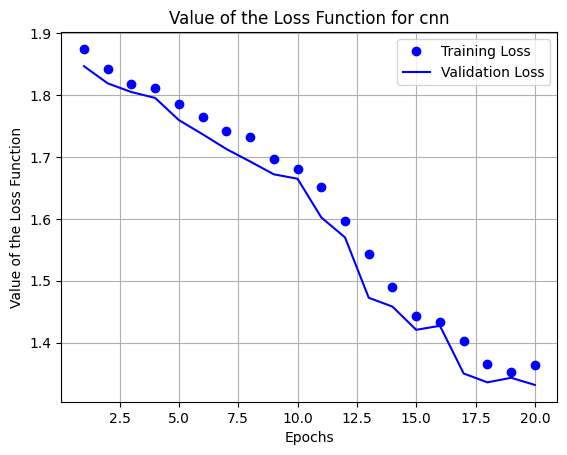

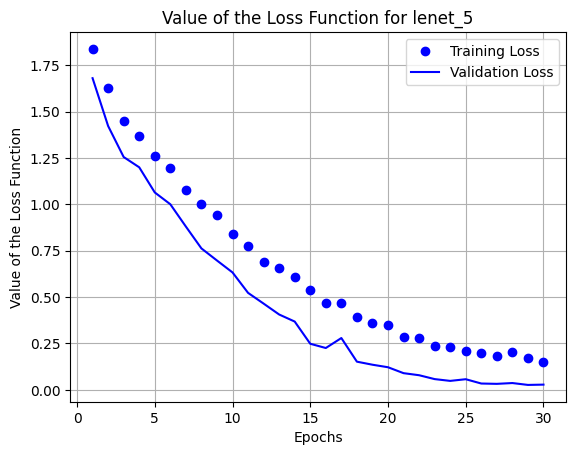

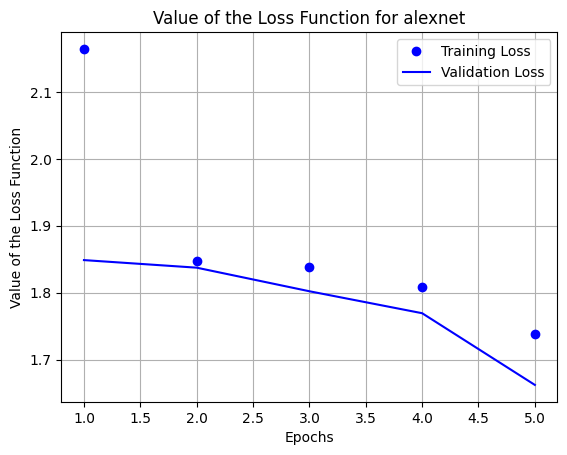

In [87]:
plot_loss_for_models(my_models)

In [88]:
def plot_accuracy_for_models(history_dict):
    for model_name, history in history_dict.items():
        # Obtener accuracy y val_accuracy
        acc = history.history['accuracy']
        acc_val = history.history['val_accuracy']
        epochs = range(1, len(acc) + 1)

        # Crear el gráfico
        plt.figure()
        plt.plot(epochs, acc, 'bo', label='Training Accuracy')
        plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
        plt.title(f'Accuracy for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Value of Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

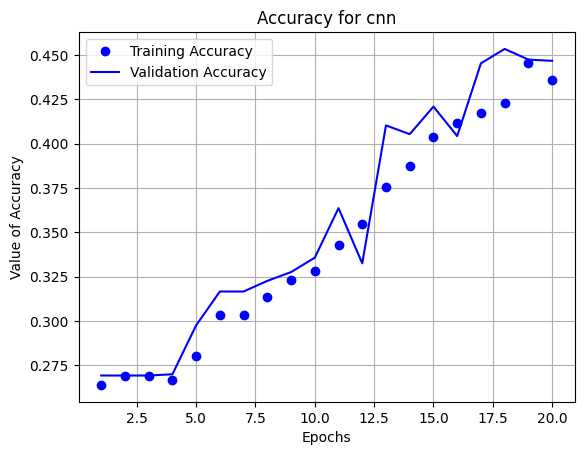

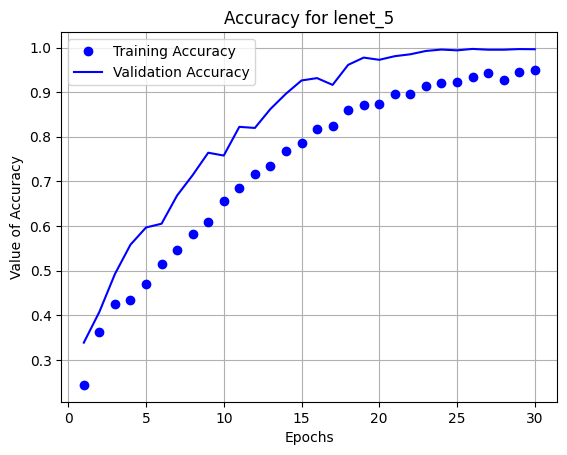

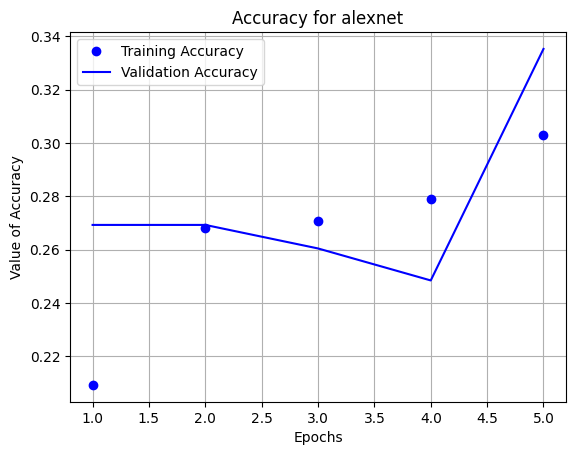

In [89]:
plot_accuracy_for_models(my_models)

# Analyse Results

In [93]:
import matplotlib.pyplot as plt

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, index):
    # Asegúrate de que el índice está dentro del rango
    if index >= len(test_image_array) or index < 0:
        raise ValueError("Índice fuera de rango")

    # Obtener la imagen y la etiqueta correspondiente
    image = test_image_array[index]
    true_label = test_image_label[index]
    predictions = pred_test_labels[index]

    # Etiquetas de las emociones (asegúrate de que estas etiquetas coinciden con el índice de predicciones)
    emotion_labels = [ "1-2 years",  "3-9 years",  "10-20 years",  "21-27 years",  "28-45 years",  "46-65 years",  "66+ years"]    # Ejemplo

    # Configurar la figura con dos subgráficas (imagen y gráfico de barras)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Mostrar la imagen
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title(f'Imagen: {true_label}')
    ax[0].axis('off')  # No mostrar los ejes

    # Mostrar el gráfico de barras
    ax[1].bar(emotion_labels, predictions, color='blue')
    ax[1].set_title('Predicciones de Ages')
    ax[1].set_xlabel('Ages')
    ax[1].set_ylabel('Probabilidad')

    plt.tight_layout()
    plt.show()

111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


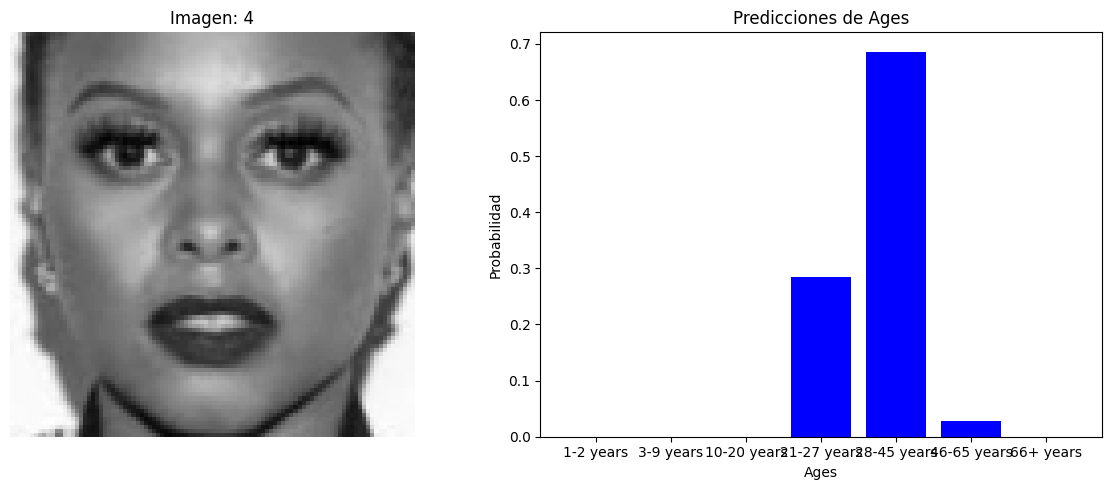

In [94]:

# Cargar el modelo
model_path = "../models/lenet.keras"
model_aux = load_model(model_path)

# Realizar predicciones en x_train
predictions = model_aux.predict(X_test)

# Para visualizar, necesitas extraer las imágenes y etiquetas
test_image_array = X_test  
test_image_label = y_test  

# Convertir las etiquetas a las clases correspondientes si es necesario
# Esto depende de si tus etiquetas son enteros o one-hot. Aquí asumimos que son enteros.
test_image_label = np.array([np.argmax(label) for label in test_image_label])

# Normalizar las predicciones (si es necesario, pero aquí se asume que ya están en la escala correcta)
pred_test_labels = predictions

# Paso 4: Llamar al método para mostrar la imagen y las predicciones
# Nota: Asegúrate de que el índice 106 esté dentro del rango de datos disponibles
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 20)

# Analyse Wrong Prediction

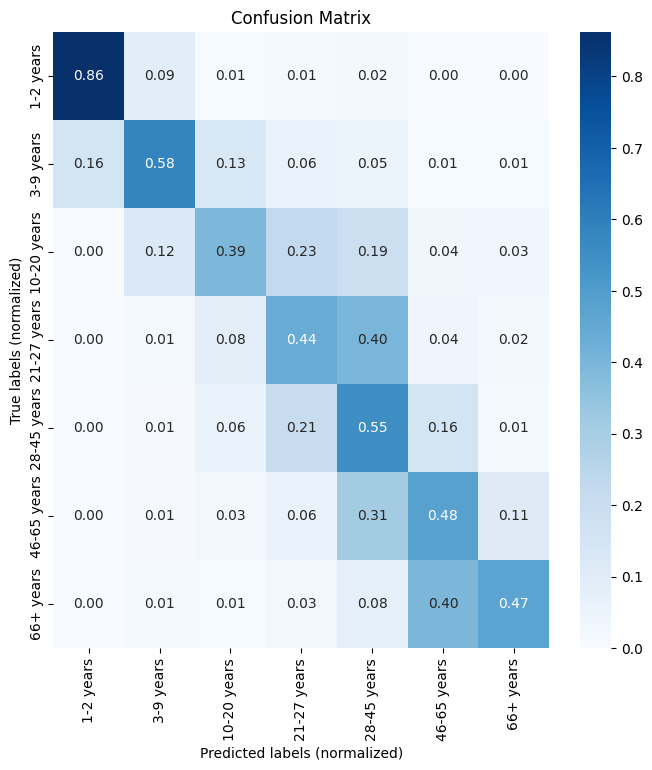

In [109]:
def create_comparison_dataframe(predictions, test_labels):
   
    # Convertir predicciones y etiquetas en índices de clases
    pred_test_labels = predictions.argmax(axis=1)
    true_labels = test_labels.argmax(axis=1)

    # Crear DataFrame de comparación
    df_compare = pd.DataFrame()
    df_compare['real'] = true_labels
    df_compare['pred'] = pred_test_labels
    df_compare['wrong'] = np.where(df_compare['real'] != df_compare['pred'], 1, 0)

    return df_compare

def plot_confusion_matrix(conf_mat, show_normed=True, show_absolute=True, class_names=None, figsize=(8, 8)):
   
    fig, ax = plt.subplots(figsize=figsize)

    # Normalizar los valores de la matriz de confusión si es necesario
    if show_normed:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(conf_mat, annot=True, fmt='.2f' if show_normed else 'd', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax)

    if show_absolute:
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
    else:
        ax.set_xlabel('Predicted labels (normalized)')
        ax.set_ylabel('True labels (normalized)')
        
    ax.set_title('Confusion Matrix')
    plt.show()
    
    return fig, ax

#
df_compare = create_comparison_dataframe(predictions, y_test)

# Calcular la matriz de confusión
conf_mat = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

# Asumiendo que tienes un diccionario de emociones como `emotions` con nombres de clases
emotions = {0: "1-2 years", 1: "3-9 years", 2: "10-20 years", 3: "21-27 years", 4: "28-45 years", 5: "46-65 years", 6: "66+ years"}

# Visualizar la matriz de confusión
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=list(emotions.values()),
                                figsize=(8, 8))

In [ ]:
# Ruta al archivo del modelo guardado
model_path = "../models/lenet.keras"

# Carga el modelo
model = load_model(model_path)
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5322 - loss: 2.2309
Precisión en el conjunto de prueba: 0.5376
Pérdida en el conjunto de prueba: 2.2460


In [123]:


def calculate_rmse_for_models(models_dict, X_test, y_test):
    
    rmse_dict = {}
    
    for model_name, model in models_dict.items():
        
        y_pred = model.predict(X_test)

        # Si y_test es one-hot encoded, conviértelo a etiquetas
        if y_test.ndim > 1 and y_test.shape[1] > 1:
            y_test_labels = y_test.argmax(axis=1)
            y_pred_labels = y_pred.argmax(axis=1)
        else:
            y_test_labels = y_test
            y_pred_labels = y_pred

        # Calcular el RMSE
        rmse = np.sqrt(mean_squared_error(y_test_labels, y_pred_labels))

        # Guardar el RMSE en el diccionario
        rmse_dict[model_name] = rmse
    
    return rmse_dict

# Uso del método
rmse_results = calculate_rmse_for_models(model_rmse, X_test, y_test)

# Imprimir los resultados
for model_name, rmse in rmse_results.items():
    print(f"RMSE for {model_name}: {rmse}")


111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 68s 602ms/step
RMSE for cnn: 1.3482186811531311
RMSE for lenet_5: 1.046137475604043
RMSE for alexnet: 1.8510840482698743
